In [ ]:
!pip uninstall umap-learn -y
!pip install umap-learn --no-cache-dir


Found existing installation: umap-learn 0.5.7
Uninstalling umap-learn-0.5.7:
  Successfully uninstalled umap-learn-0.5.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00


In [ ]:


# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import umap



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load dataset with low_memory=False to avoid DtypeWarning
df = pd.read_csv('/content/drive/MyDrive/X-IIoTID dataset.csv', low_memory=False)

# Check data types
print(df.dtypes)

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("\nNon-numeric columns:", non_numeric_cols)


Date                           object
Timestamp                      object
Scr_IP                         object
Scr_port                       object
Des_IP                         object
                                ...  
read_write_physical.process     int64
is_privileged                   int64
class1                         object
class2                         object
class3                         object
Length: 68, dtype: object

Non-numeric columns: Index(['Date', 'Timestamp', 'Scr_IP', 'Scr_port', 'Des_IP', 'Des_port',
       'Protocol', 'Service', 'Duration', 'Scr_bytes', 'Des_bytes',
       'missed_bytes', 'is_syn_only', 'Is_SYN_ACK', 'is_pure_ack',
       'is_with_payload', 'FIN or RST', 'Bad_checksum', 'is_SYN_with_RST',
       'Scr_pkts', 'Scr_ip_bytes', 'Des_pkts', 'Des_ip_bytes', 'anomaly_alert',
       'total_bytes', 'total_packet', 'paket_rate', 'byte_rate',
       'Scr_packts_ratio', 'Des_pkts_ratio', 'Scr_bytes_ratio',
       'Des_bytes_ratio', 'Avg_user_time', 

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in non_numeric_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))  # Convert to string first

print("Categorical columns converted to numeric!")

Categorical columns converted to numeric!


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select only numeric features (excluding target columns)
X = df.drop(columns=['class1', 'class2', 'class3'])
y_binary = df['class1']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaling successful!")

Scaling successful!


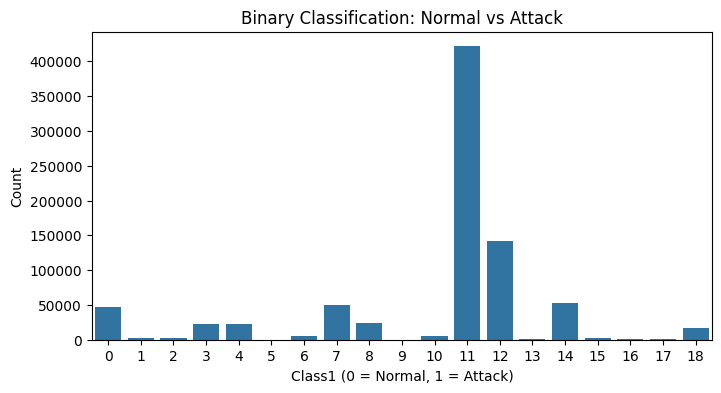

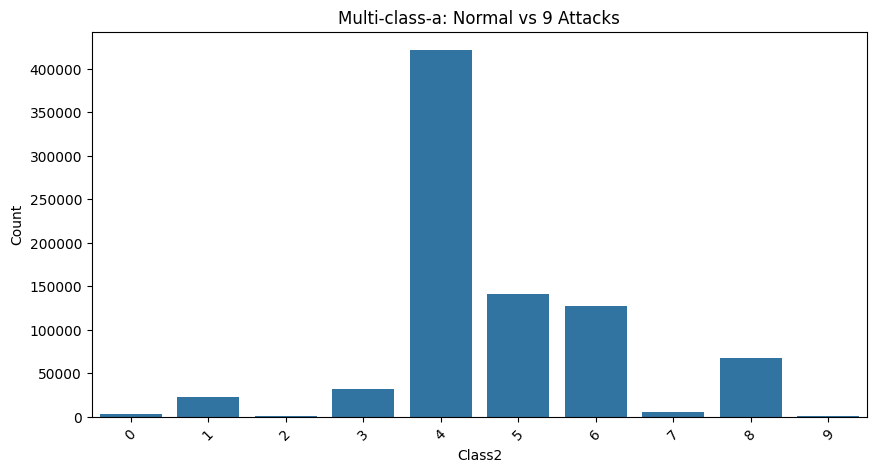

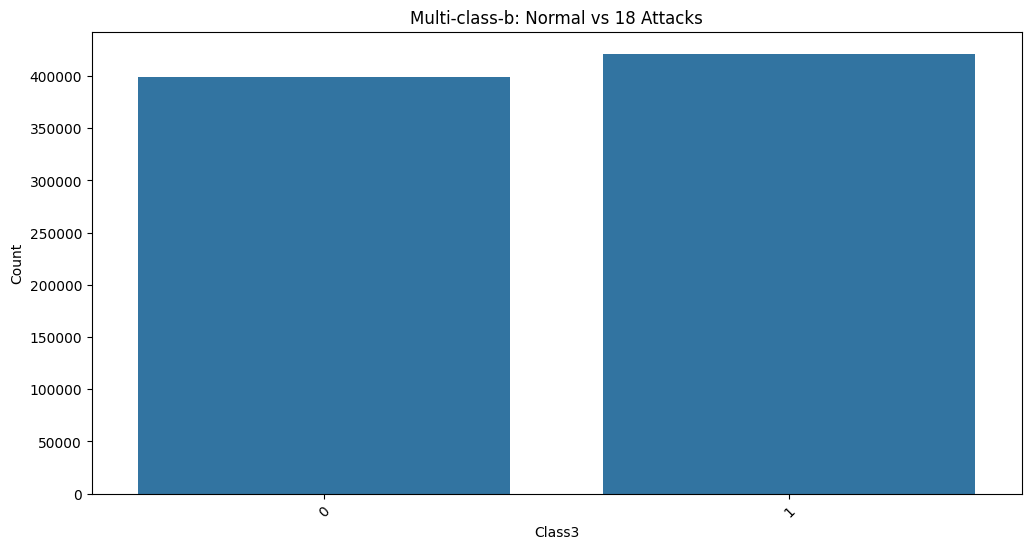

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for class1 (Binary Classification)
plt.figure(figsize=(8, 4))
sns.countplot(x=df['class1'])
plt.title('Binary Classification: Normal vs Attack')
plt.xlabel('Class1 (0 = Normal, 1 = Attack)')
plt.ylabel('Count')
plt.show()

# Plot for class2 (Multi-class-a: Normal vs 9 Attacks)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['class2'])
plt.title('Multi-class-a: Normal vs 9 Attacks')
plt.xlabel('Class2')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot for class3 (Multi-class-b: Normal vs 18 Attacks)
plt.figure(figsize=(12, 6))
sns.countplot(x=df['class3'])
plt.title('Multi-class-b: Normal vs 18 Attacks')
plt.xlabel('Class3')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Drop unnecessary columns
drop_cols = ['Date', 'Timestamp', 'Scr_IP', 'Des_IP', 'Scr_port', 'Des_port']
df_filtered = df.drop(columns=drop_cols, errors='ignore')

# Sample dataset: Take 5000 instances per class
df_sampled = df_filtered.groupby('class1', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000), random_state=42))

# Convert categorical columns (if any remain)
df_sampled = pd.get_dummies(df_sampled)

# Train-Test Split for Class1
X = df_sampled.drop(columns=['class1', 'class2', 'class3'])
y_class1 = df_sampled['class1']

X_train, X_test, y_train, y_test = train_test_split(X, y_class1, test_size=0.2, random_state=42, stratify=y_class1)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Reduced dataset prepared for BERT training. Total Samples:", len(X_train_sm))


<ipython-input-7-8f395d388a9a>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_filtered.groupby('class1', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000), random_state=42))


Reduced dataset prepared for BERT training. Total Samples: 76000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# ✅ Load Dataset (Ensure `df` is defined before running)
# df = pd.read_csv("your_dataset.csv")  # Uncomment if loading from CSV

# ✅ Load Pretrained BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Encode 'class1' column to numeric labels
label_encoder = LabelEncoder()
df["class1"] = label_encoder.fit_transform(df["class1"])
num_classes = len(label_encoder.classes_)  # 🔹 Dynamically get class count

# ✅ Custom Dataset Class
class IoTDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=64,  # 🔹 Reduce max token length to save memory
            return_tensors="pt"
        )
        encoding.pop("token_type_ids", None)  # 🔹 Remove token_type_ids

        return {key: val.squeeze(0) for key, val in encoding.items()}, torch.tensor(label, dtype=torch.long)

# ✅ Sample Data for Training
small_df = df.sample(n=10000, random_state=42)  # 🔹 Reduce dataset size for efficiency
train_texts = (small_df["Protocol"].astype(str) + " " +
               small_df["Service"].astype(str) + " " +
               small_df["Conn_state"].astype(str)).tolist()
train_labels = small_df["class1"].tolist()

# ✅ Create PyTorch Dataset & DataLoader
batch_size = 8  # 🔹 Reduce batch size to avoid RAM overload
train_dataset = IoTDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# ✅ Define Optimized BERT Model
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

# ✅ Initialize Model, Loss & Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# ✅ Training Loop with Memory Optimization
num_epochs = 3
accumulation_steps = 2  # 🔹 Accumulate gradients before updating weights

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    optimizer.zero_grad()
    for step, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps  # 🔹 Normalize loss by accumulation steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # 🔹 Undo normalization for logging
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

# ✅ Save Model
torch.save(model.state_dict(), "bert_iot_model.pth")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.9591, Accuracy: 0.7315
Epoch 2, Loss: 0.7368, Accuracy: 0.7540
Epoch 3, Loss: 0.7145, Accuracy: 0.7569


In [ ]:
num_epochs = 10  # 🔹 Increase from 3 to 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # 🔹 Reduce LR every 3 epochs

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    optimizer.zero_grad()
    for step, batch in enumerate(train_loader):
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps  # 🔹 Normalize loss by accumulation steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # 🔹 Undo normalization for logging
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # 🔹 Adjust learning rate

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch 1, Loss: 0.7053, Accuracy: 0.7567
Epoch 2, Loss: 0.6988, Accuracy: 0.7589
Epoch 3, Loss: 0.6955, Accuracy: 0.7574
Epoch 4, Loss: 0.6852, Accuracy: 0.7595
Epoch 5, Loss: 0.6856, Accuracy: 0.7594
Epoch 6, Loss: 0.6847, Accuracy: 0.7596
Epoch 7, Loss: 0.6824, Accuracy: 0.7599
Epoch 8, Loss: 0.6806, Accuracy: 0.7596
Epoch 9, Loss: 0.6798, Accuracy: 0.7596
Epoch 10, Loss: 0.6782, Accuracy: 0.7594


In [ ]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Protocol"].astype(str) + " " + df["Service"].astype(str) + " " + df["Conn_state"].astype(str),
    df["class1"],
    test_size=0.2,
    random_state=42
)


In [ ]:
# Create test dataset
test_dataset = IoTDataset(test_texts.tolist(), test_labels.tolist())

# Create test DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9392
           1       0.48      0.34      0.40       601
           2       0.60      0.99      0.74       529
           3       0.00      0.00      0.00      4733
           4       0.00      0.00      0.00      4455
           5       0.00      0.00      0.00         6
           6       0.49      1.00      0.66      1017
           7       0.61      0.99      0.75     10121
           8       0.99      0.53      0.69      4664
           9       0.00      0.00      0.00        20
          10       0.96      1.00      0.98      1195
          11       0.76      0.96      0.85     84303
          12       0.84      1.00      0.91     28156
          13       0.00      0.00      0.00       192
          14       1.00      0.00      0.00     10600
          15       0.76      0.66      0.71       388
          16       0.00      0.00      0.00        85
          17       0.00    

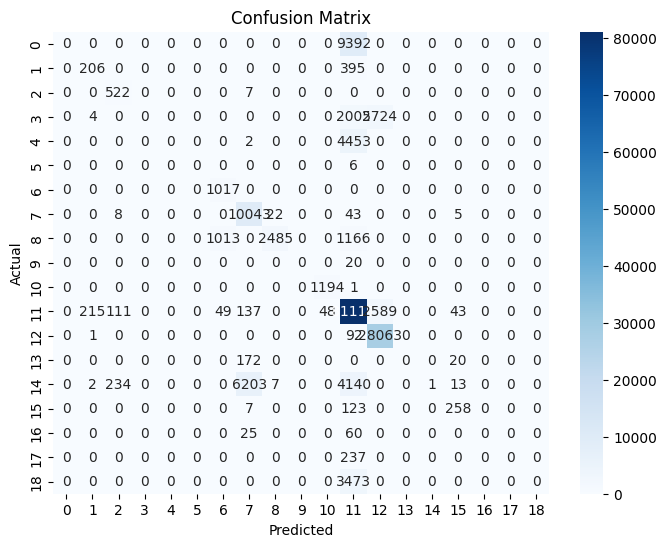

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run model inference on test data
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Print classification report
print(classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
